# Tutorial

The general workflow for using GEMsembler is as follows:
1. Collecting initial models (input)
2. Creating supermodel (automatic)
3. Assembling consensus models  (automatic)
4. Initial check for production of all potential biomass components on known media (automatic, heatmap/table generated)
5. Biomass curation
    a. Table with model agreement on biomass components (automatic)
    b. Decisions on including each biomass component and adding the corresponding column with yes/no (manual, but based on automatically generated files from steps 5.a and 4 and optionally any other information)
    c. Small COBRApy manipulations on the biomass to implement the decision from the 5.b table
6. Curation for growth
    a. Checking for the production of final biomass components in all consensus models and corresponding pFBA pathways  (automatic, summary heatmap/table and all pathways are generated in one function)
    b. Selecting a base consensus level  (single decision based on step 6.a)
    c. Browsing through pathway maps (automatically generated at step 6.a) for each biomass component, not produced at the base consensus level and selecting reactions to add (manual)
    d. Combining base consensus with the selected reactions (automatic)
    e. Checking the production of each biomass component in the combined models with small COBRApy manipulations
    f. Optionally selecting any other reactions to include/exclude in the final model based on available knowledge.
    g. The final combination of base consensus and selected reactions (automatic)
    h. NGAM: setting ATPM reaction lower boundary (manual)
7. GPR curation with gene essentiality data (optionally, if data is available; automatically calculated in Python with supermodel: this functionality is not part of the GEMsembler package itself, but the code can be adapted from the paper scripts)

## Import

We load all the necessary classes and functions

In [43]:
from gemsembler import (
    GatheredModels,  # Object to collect input models and build a supermodel
    read_supermodel_from_json,  # Function to read a save supermodel
    get_models_with_all_confidence_levels,  # creates cobrapy models at all confidence levels
    get_model_of_interest  # creates one cobrapy model
)

from gemsembler.downstream import (
    glycolysis,  # returns table and/or interactive maps of glycolysis 
    pentose_phosphate,  # returns table and/or interactive maps of pentose phosphate
    tca,  # # returns table and/or interactive maps of TCA
    # table_reactions_confidence,  # returns a pandas dataframe with reaction IDs, confidence and additional info
    # calc_dist_for_synt_path,
    biomass, 
    get_met_neighborhood,
    # run_metquest_results_analysis, 
    run_growth_full_flux_analysis, 
    # write_metabolites_production_output, 
    pathway_of_interest, 
    # get_met_neighborhood, 
    GLYCOLYSIS_GLOBAL, 
    PENTOSE_PHOSPHATE_PATHWAY_GLOBAL, 
    TCA_GLOBAL, 
    COFACTORS_GLOBAL
)

from gemsembler.drawing import draw_one_synt_path, MET_NOT_INT_GLOBAL
from cobra.io import read_sbml_model, write_sbml_model

An example set of models is included in the package, which can be accessed as follows:

In [19]:
from gemsembler import lp_example

lp_example

[{'model_id': 'agora_LP',
  'path_to_model': PosixPath('/home/bartosz/Documents/Heidelberg/EMBL/Bioinformatician/Software/Packages/GEMsembler/worktrees/dev/src/gemsembler/data/LP/LP_agora_model.xml.gz'),
  'model_type': 'agora',
  'path_to_genome': PosixPath('/home/bartosz/Documents/Heidelberg/EMBL/Bioinformatician/Software/Packages/GEMsembler/worktrees/dev/src/gemsembler/data/LP/LP_genome_agora.fna.gz')},
 {'model_id': 'carveme_LP',
  'path_to_model': PosixPath('/home/bartosz/Documents/Heidelberg/EMBL/Bioinformatician/Software/Packages/GEMsembler/worktrees/dev/src/gemsembler/data/LP/LP_carveme_model.xml.gz'),
  'model_type': 'carveme',
  'path_to_genome': PosixPath('/home/bartosz/Documents/Heidelberg/EMBL/Bioinformatician/Software/Packages/GEMsembler/worktrees/dev/src/gemsembler/data/LP/LP_genome.faa.gz')},
 {'model_id': 'gapseq_LP',
  'path_to_model': PosixPath('/home/bartosz/Documents/Heidelberg/EMBL/Bioinformatician/Software/Packages/GEMsembler/worktrees/dev/src/gemsembler/data/LP/

`lp_example` is a list of dictionaries which are individually 
passed to `add_model` function of `GatheredModels` class instance

## Conversion and gathering

First, we create an instance of `GatheredModels`, 
which serves as an object that collects individual models 
and is then used to create a supermodel object.

Each model can be added separetly with with `add_model` 
function from `GatheredModels` class. 

Then `run` function is invoked to run the all the 
stages of conversion on all the models.

In [20]:
gathered = GatheredModels()
for model in lp_example:
    gathered.add_model(**model)
gathered.run()

Running initial convertion
Running 1st structural convertion
Running structural suggestions for metabolites
Running 2d structural convertion
Introducing periplasmic compartment


## Assembling supermodel

After the conversion is finished, we can create a `supermodel` object with
`assemble_supermodel` function. The function needs an output folder as an argument 
and takes further optional arguments, such as `assembly_id` to download the 
genome from NCBI.

In [21]:
supermodel_lp = gathered.assemble_supermodel("./gemsembler_output/", assembly_id = "GCF_000203855.3")

Building BLAST database
Building BLAST database
Running gene conversion with BLAST for agora_LP
Running gene conversion with BLAST for carveme_LP
Running gene conversion with BLAST for gapseq_LP
Running gene conversion with BLAST for modelseed_LP
Assembling Supermodel
Creating metabolites for supermodel
Creating reactions for supermodel
Creating genes for supermodel
Connecting supermodel network
Finalizing supermodel attributes


Alternatively, path to pre-downloaded genome can be specified with `path_final_genome_aa` keyword argument:
```python
supermodel_lp = gathered.assemble_supermodel("./gemsembler_output/", path_final_genome_aa = "./gemsembler_output/final_aa_GCF_000203855.3.faa")
```

We recommend creating two supermodels for a given set of models - one 
where metabolites and reactions that could not be converted are not 
incorporated into the supermodel (default behavious) and one where they
are, which can be achieved with setting `do_mix_conv_notconv` argument to 
`True`.

In [22]:
supermodel_lp_mix = gathered.assemble_supermodel("./gemsembler_output/", assembly_id = "GCF_000203855.3", do_mix_conv_notconv=True)

Building BLAST database
Building BLAST database
Running gene conversion with BLAST for agora_LP
Running gene conversion with BLAST for carveme_LP
Running gene conversion with BLAST for gapseq_LP
Running gene conversion with BLAST for modelseed_LP
Assembling Supermodel
Creating metabolites for supermodel
Creating reactions for supermodel
Creating genes for supermodel
Connecting supermodel network
Finalizing supermodel attributes


### Reading and writing a supermodel

A supermodel can be saved to a file in a json format as follows:

In [23]:
supermodel_lp.write_supermodel_to_json("./gemsembler_output/lp_supermodel.json")

And then read from a json file as follows:

In [24]:
supermodel_lp = read_supermodel_from_json("./gemsembler_output/lp_supermodel.json")

loading supermodel...
loading SetofNewElements...
loading SetofNewElements...
loading SetofNewGenes...


## Comparing input models with supermodel and geting ensembled models

Once a supermodel object is created, we can do various comparisons. For example, we 
can get all the metabolites and reactions that are in at least two models by running 
`at_least_in` function, as shown below. This function will modify supermodel's 
metabolites and reactions attributes to contain information on this comparison.

In [25]:
supermodel_lp.at_least_in(2)

Results are saved in 'comparison' attribute as core2


A supermodel object can be converted to a cobrapy model object using `get_model_of_interest` function:

In [26]:
core2 = get_model_of_interest(supermodel_lp, "core2")

with an option to save the model in SBML format by specifying `output_name` argument:

In [27]:
core2 = get_model_of_interest(supermodel_lp, "core2", "./gemsembler_output/lp_core2.xml")

(<Model core2 at 0x77321f5a4b60>,
 {'COBRA_CHECK': [],
  'COBRA_ERROR': [],
  'COBRA_FATAL': [],
  'COBRA_WARNING': [],
  'SBML_ERROR': [],
  'SBML_FATAL': [],
  'SBML_SCHEMA_ERROR': [],
  'SBML_WARNING': []})


Different comparisons can be performed:

In [19]:
supermodel_lp.exactly_in(2)

Results are saved in 'comparison' attribute as In2


In [22]:
supermodel_lp.get_intersection()

Results are saved in 'comparison' attribute as core5


In [21]:
supermodel_lp.present(yes=["curated_LP", "agora_LP"], no=["cagram_LP"])

Results are saved in 'comparison' attribute as Yes_agocur_No_cag


In [23]:
supermodel_lp.get_short_name_len()

3

In [25]:
supermodel_lp.get_venn_segments()

Results are saved in 'comparison' attribute as Yes_cur_No_agocagcaumsg
Results are saved in 'comparison' attribute as Yes_cau_No_agocagcurmsg
Results are saved in 'comparison' attribute as Yes_cag_No_agocaucurmsg
Results are saved in 'comparison' attribute as Yes_msg_No_agocagcaucur
Results are saved in 'comparison' attribute as Yes_ago_No_cagcaucurmsg
Results are saved in 'comparison' attribute as Yes_caucur_No_agocagmsg
Results are saved in 'comparison' attribute as Yes_cagcur_No_agocaumsg
Results are saved in 'comparison' attribute as Yes_curmsg_No_agocagcau
Results are saved in 'comparison' attribute as Yes_agocur_No_cagcaumsg
Results are saved in 'comparison' attribute as Yes_cagcau_No_agocurmsg
Results are saved in 'comparison' attribute as Yes_caumsg_No_agocagcur
Results are saved in 'comparison' attribute as Yes_agocau_No_cagcurmsg
Results are saved in 'comparison' attribute as Yes_cagmsg_No_agocaucur
Results are saved in 'comparison' attribute as Yes_agocag_No_caucurmsg
Result

### Confidence

The wrapper function below runs `at_least_in()` function for all the possibilities:

In [28]:
supermodel_lp.get_all_confidence_levels()

Results are saved in 'comparison' attribute as core4
Results are saved in 'comparison' attribute as core3
Results are saved in 'comparison' attribute as core2


and all these comparisons can be saved with `get_models_with_all_confidence_levels()` 
function by providing a model and a path to an output folder:

In [29]:
lp_gems_conflev = get_models_with_all_confidence_levels(
    supermodel_lp, 
    "./gemsembler_output/output_gems_confidence_levels/"
)

(<Model agora_LP at 0x77321b265400>,
 {'COBRA_CHECK': [],
  'COBRA_ERROR': [],
  'COBRA_FATAL': [],
  'COBRA_WARNING': [],
  'SBML_ERROR': [],
  'SBML_FATAL': [],
  'SBML_SCHEMA_ERROR': [],
  'SBML_WARNING': []})
(<Model carveme_LP at 0x7731136855e0>,
 {'COBRA_CHECK': [],
  'COBRA_ERROR': [],
  'COBRA_FATAL': [],
  'COBRA_WARNING': [],
  'SBML_ERROR': [],
  'SBML_FATAL': [],
  'SBML_SCHEMA_ERROR': [],
  'SBML_WARNING': []})
(<Model gapseq_LP at 0x773119592e40>,
 {'COBRA_CHECK': [],
  'COBRA_ERROR': [],
  'COBRA_FATAL': [],
  'COBRA_WARNING': [],
  'SBML_ERROR': [],
  'SBML_FATAL': [],
  'SBML_SCHEMA_ERROR': [],
  'SBML_WARNING': []})
(<Model modelseed_LP at 0x77310ff82e70>,
 {'COBRA_CHECK': [],
  'COBRA_ERROR': [],
  'COBRA_FATAL': [],
  'COBRA_WARNING': [],
  'SBML_ERROR': [],
  'SBML_FATAL': [],
  'SBML_SCHEMA_ERROR': [],
  'SBML_WARNING': []})


/home/bartosz/Documents/Heidelberg/EMBL/Bioinformatician/Software/Packages/GEMsembler/worktrees/dev/src/gemsembler/anticreation.py:269: UserWarning: Some expected biomass products are not found: h_c
  warnings.warn(


(<Model core4 at 0x77310fcb5e50>,
 {'COBRA_CHECK': [],
  'COBRA_ERROR': [],
  'COBRA_FATAL': [],
  'COBRA_WARNING': [],
  'SBML_ERROR': [],
  'SBML_FATAL': [],
  'SBML_SCHEMA_ERROR': [],
  'SBML_WARNING': []})
(<Model core3 at 0x77310f4d9640>,
 {'COBRA_CHECK': [],
  'COBRA_ERROR': [],
  'COBRA_FATAL': [],
  'COBRA_WARNING': [],
  'SBML_ERROR': [],
  'SBML_FATAL': [],
  'SBML_SCHEMA_ERROR': [],
  'SBML_WARNING': []})
(<Model core2 at 0x77310ebd1dc0>,
 {'COBRA_CHECK': [],
  'COBRA_ERROR': [],
  'COBRA_FATAL': [],
  'COBRA_WARNING': [],
  'SBML_ERROR': [],
  'SBML_FATAL': [],
  'SBML_SCHEMA_ERROR': [],
  'SBML_WARNING': []})
(<Model assembly at 0x77310d992240>,
 {'COBRA_CHECK': [],
  'COBRA_ERROR': [],
  'COBRA_FATAL': [],
  'COBRA_WARNING': [],
  'SBML_ERROR': [],
  'SBML_FATAL': [],
  'SBML_SCHEMA_ERROR': [],
  'SBML_WARNING': []})


these models can be then be read with the standard cobrapy `read_sbml_model()` function:

In [30]:
lp_model_list = ["core4", "core3", "core2", "assembly", "carveme_LP", "gapseq_LP", "modelseed_LP", "agora_LP"]
lp_gems_conflev = {
    model: read_sbml_model(f"./gemsembler_output/output_gems_confidence_levels/{model}.xml")
    for model in lp_model_list
}

## General caracteristics

Central carbon pathway

GEMsembler comes with dictionaries that represent pathways such as 
glycolysis, TCA cycle and pentose phosphate pathway. Dictionary for 
glycolysis is shown below with reactions as key and list of 
metabolites as values in the given dictionary:

In [31]:
GLYCOLYSIS_GLOBAL

{'HEX1': [('glc__D_c', 'g6p_c')],
 'PGI': [('g6p_c', 'f6p_c')],
 'PFK': [('f6p_c', 'fdp_c')],
 'FBA': [('fdp_c', 'g3p_c')],
 'GAPD': [('g3p_c', '13dpg_c')],
 'PGK': [('13dpg_c', '3pg_c')],
 'PGM': [('3pg_c', '2pg_c')],
 'ENO': [('2pg_c', 'pep_c')],
 'PYK': [('pep_c', 'pyr_c')]}

Furthermore, GEMsembler can plot the above mentioned pathways and return 
a table with confidence in each reaction based on the set of submitted models:

In [39]:
gp, gt = glycolysis(
    supermodel_lp, 
    draw_pathway_to_file="./gemsembler_output/general_characteristics/glycolysis.html", 
    write_table_to_file="./gemsembler_output/general_characteristics/glycolysis.tsv"
)

ppp, ppt = pentose_phosphate(
    supermodel_lp, 
    draw_pathway_to_file="./gemsembler_output/general_characteristics/pentose_phosphate.html", 
    write_table_to_file="./gemsembler_output/general_characteristics/pentose_phosphate.tsv"
)

tp, tt = tca(
    supermodel_lp, 
    draw_pathway_to_file="./gemsembler_output/general_characteristics/tca.html", 
    write_table_to_file="./gemsembler_output/general_characteristics/tca.tsv"
)

similarly for biomass:

In [45]:
lp_g_bio, lp_t_bio = biomass(
    supermodel_lp, 
    draw_plot_to_file="./gemsembler_output/general_characteristics/lp_biomass.html", 
    write_table_to_file="./gemsembler_output/general_characteristics/lp_biomass.tsv"
)

and for neigborhood of a given metabolite:

In [46]:
graph, all_r, all_g, all_m = get_met_neighborhood(
    supermodel_lp, 
    metabolite_id="ala__D_c", 
    draw_neiborhood_to_file="./gemsembler_output/general_characteristics/ala__D_c_neigborhood.html"
)

## FBA growth and synthesis

We can also do FBA analysis with GEMsembler. First, we define the nutrients within a medium (e.g. pmm5 medium):

In [48]:
pmm5 = ['pi',
 'glc__D',
 'na1',
 'ac',
 'ascb__L',
 'arg__L',
 'glu__L',
 'ile__L',
 'leu__L',
 'met__L',
 'phe__L',
 'thr__L',
 'trp__L',
 'tyr__L',
 'val__L',
 'nac',
 'pnto__R',
 'ribflv',
 'mg2',
 'cl',
 'ca2',
 'mn2',
 'fe3',
 'fe2',
 'zn2',
 'so4',
 'cobalt2',
 'cu',
 'mobd',
 'k',
 'cu2',
 'h2o',
 'h']

nutrit_pmm5 = ["glc__D", "ascb__L", "arg__L", "glu__L", "ile__L", "leu__L", "met__L", "phe__L", "thr__L", "trp__L", "tyr__L", "val__L", "pnto__R"]
pmm5_dict = {m+"_e": 10 if m in nutrit_pmm5 else 1000 for m in pmm5}

With `run_growth_full_flux_analysis()` function, we can run FBA analysis and get various tables and plots:

Running FBA block for core5 model
Running FBA block for core4 model
Running FBA block for core3 model
Running FBA block for core2 model
Running FBA block for assembly model
Running FBA block for curated_LP model
Running FBA block for cauniv_LP model
Running FBA block for cagram_LP model
Running FBA block for msgram_LP model
Running FBA block for agora_LP model


/home/mek/.conda/envs/gemsembler_tutorial/lib/python3.11/site-packages/gemsembler/downstream.py:1325: UserWarning: Models for which to draw pfba of biomass precursors is not provided. So for each biomass precursor the model with the highest confidence level will be used.
  warnings.warn(


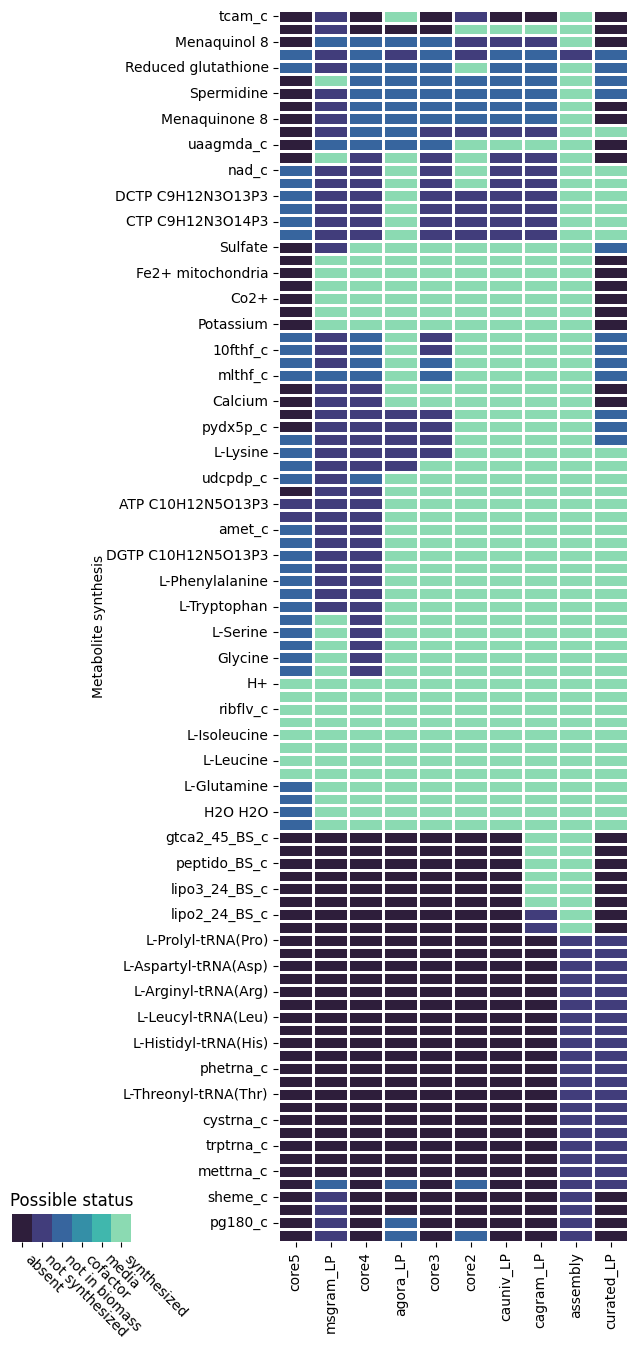

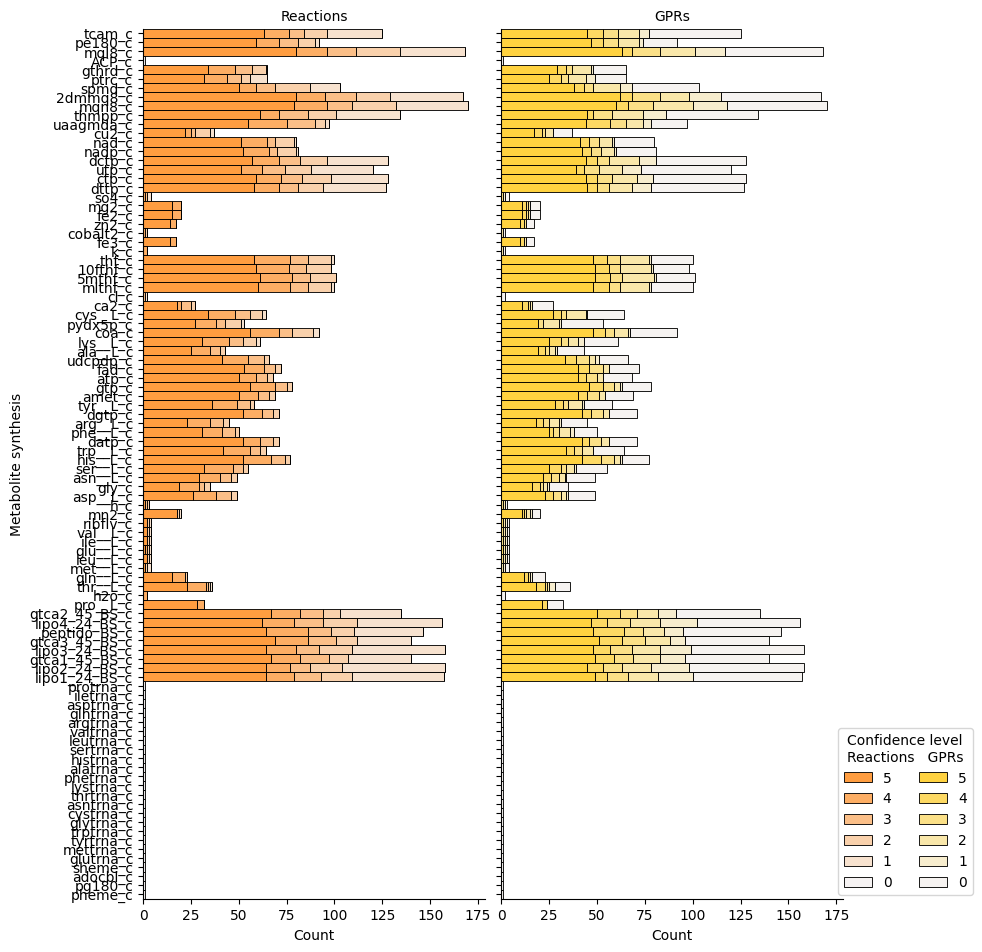

In [21]:
lp_fba_production_tab, lp_fba_production_plots, lp_flux_res_out, lp_path_pfba_out, lp_fba_stat_out_tab = run_growth_full_flux_analysis(
    lp_gems_conflev, 
    pmm5_dict, 
    supermodel_lp, 
    "./gemsembler_output/growth_min_media/", 
    output_folder_mq_paths_plots="./gemsembler_output/growth_min_media/single_met_pfba_plots/", 
    output_folder_mq_paths_tables="./gemsembler_output/growth_min_media/single_met_pfba_tables/"
)

In [26]:
fad_ca_path = [r for r in lp_path_pfba_out["cagram_LP"]["fad_c"] if not r.startswith("DM_")]
fad_g_ca_lp = draw_one_synt_path(supermodel_lp, fad_ca_path, pmm5_c, ["fad_c"], "./gemsembler_output/growth_min_media/single_met_pfba_plots/fad_c_cagram_LP.html", draw_met_not_int=True)

In [32]:
r_lys_ca_lp = [supermodel_lp.reactions.assembly["ADPDS"], supermodel_lp.reactions.assembly["ADPTA"], supermodel_lp.reactions.assembly["APATi"], supermodel_lp.reactions.assembly["DHDPRy"]]
rtr_arg_lp = [supermodel_lp.reactions.assembly["ARGt2r"]]

In [37]:
tmp_core3_cur = get_model_of_interest(supermodel_lp, "core3", gene_interest_level="core2", biomass_interest_level="assembly", reactions_include=r_lys_ca_lp, reactions_exclude=rtr_arg_lp)